In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
import datetime

In [ ]:
def display_images(original_imgs, blurred_imgs, deblurred_imgs, num_examples=5):
    plt.figure(figsize=(12, num_examples * 2.5))
    for i in range(num_examples):

        ax = plt.subplot(num_examples, 3, i * 3 + 1)
        plt.imshow(np.clip(original_imgs[i], 0, 1))
        plt.title("Originale")
        plt.axis("off")

        ax = plt.subplot(num_examples, 3, i * 3 + 2)
        plt.imshow(np.clip(blurred_imgs[i], 0, 1))
        plt.title("Blurred (Input)")
        plt.axis("off")

        ax = plt.subplot(num_examples, 3, i * 3 + 3)
        plt.imshow(np.clip(deblurred_imgs[i], 0, 1))
        plt.title("De-blurred")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

def ssim_metric(y_true, y_pred):
    y_true = tf.image.convert_image_dtype(y_true, dtype=tf.float32)
    y_pred = tf.image.convert_image_dtype(y_pred, dtype=tf.float32)
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def psnr_metric(y_true, y_pred):
    y_true = tf.image.convert_image_dtype(y_true, dtype=tf.float32)
    y_pred = tf.image.convert_image_dtype(y_pred, dtype=tf.float32)
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #Singolo strato convoluzionale per semplificare il modello
    #x = Conv2D(num_filters, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)
    return x

def decoder_block(input_tensor, skip_tensor, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    x = concatenate([x, skip_tensor], axis=3)
    x = conv_block(x, num_filters)
    return x

## Gaussian Blur

Caricamento del dataset LFW (volti interi)...
Dataset caricato: 7606 immagini, dimensioni originali (dopo fetch resize): 125x94x3
Ridimensionamento immagini a 128x96...
Immagini elaborate per il modello: 7606 immagini di dimensioni 128x96x3
Creazione delle immagini sfocate...

 Immagini blurrate usando Gaussian Blur


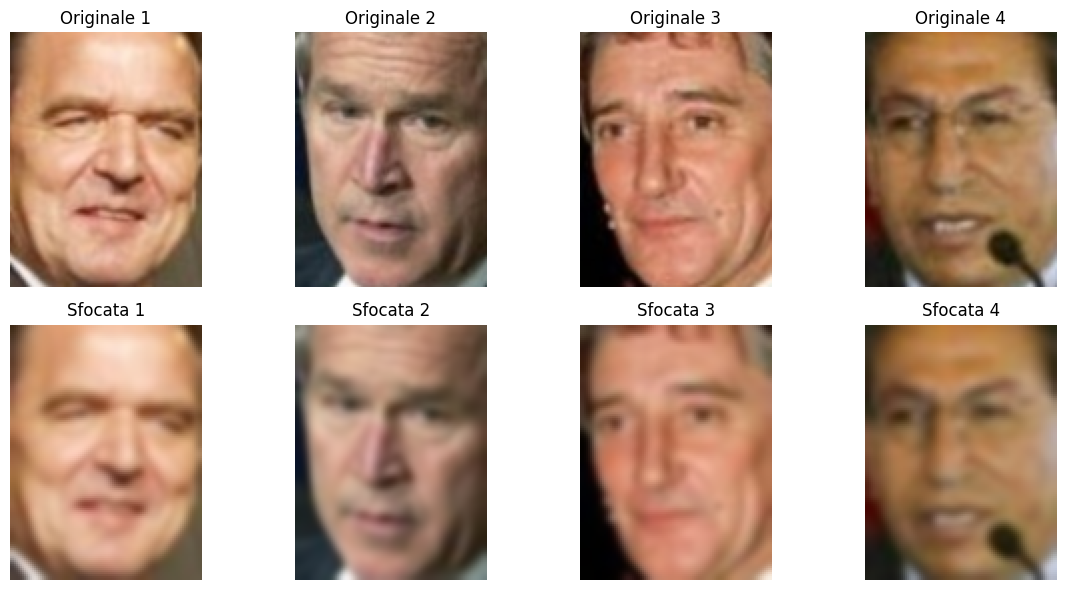

In [ ]:
print("Caricamento del dataset LFW (volti interi)...")

lfw_people = fetch_lfw_people(min_faces_per_person=3, resize=1, color=True)


original_images_from_fetch = lfw_people.images
if original_images_from_fetch.ndim == 3:
    original_images_from_fetch = np.expand_dims(original_images_from_fetch, axis=-1)
    print("Immagini convertite in formato con canale colore.")

n_samples_fetch, h_fetch, w_fetch, c_fetch = original_images_from_fetch.shape
print(f"Dataset caricato: {n_samples_fetch} immagini, dimensioni originali (dopo fetch resize): {h_fetch}x{w_fetch}x{c_fetch}")

target_h = 128 # Divisibile per 8
target_w = 96 # Divisibile per 8 (aspect ratio circa 4:3)

print(f"Ridimensionamento immagini a {target_h}x{target_w}...")
resized_images_list = []
for img in original_images_from_fetch:
    resized_img = cv2.resize(img, (target_w, target_h), interpolation=cv2.INTER_AREA)
    resized_images_list.append(resized_img)

X = np.array(resized_images_list).astype(np.float32)
if X.max() > 1.0: # Normalizzazione se non già fatta (LFW dovrebbe essere già [0,1])
    X = X / 255.0
X = np.clip(X, 0.0, 1.0)

n_samples, h, w, c = X.shape
print(f"Immagini elaborate per il modello: {n_samples} immagini di dimensioni {h}x{w}x{c}")
if c != 3:
    print(f"ATTENZIONE: Numero di canali inatteso: {c}. Previsti 3 canali colore.")
    # Tentativo di correzione se le immagini sono in scala di grigi
    if c == 1:
        X = np.concatenate([X, X, X], axis=-1)
        c = X.shape[-1]
        print(f"Immagini convertite forzatamente a {c} canali.")


# 3. Creazione delle immagini sfocate
print("Creazione delle immagini sfocate...")
blurred_images = np.zeros_like(X)
blur_kernel_size = (9, 9)
blur_sigma = 1.7

for i in range(len(X)):
    blurred_images[i] = cv2.GaussianBlur(X[i], blur_kernel_size, blur_sigma)
blurred_images = np.clip(blurred_images, 0.0, 1.0)

print("\n Immagini blurrate usando Gaussian Blur")
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    # Immagini originali
    axes[0, i].imshow(X[i])
    axes[0, i].set_title(f'Originale {i+1}')
    axes[0, i].axis('off')

    # Immagini sfocate
    axes[1, i].imshow(blurred_images[i])
    axes[1, i].set_title(f'Sfocata {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Dimensioni Training set: 6084 campioni, shape: (6084, 128, 96, 3)
Dimensioni Test set: 1522 campioni, shape: (1522, 128, 96, 3)
Input shape per il modello: (128, 96, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 96,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 96,   │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 96,   │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 96,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 48,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 48,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 48,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 24,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 24,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 24,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 24,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 12,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 12,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 16, 12,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 24,    │    131,200 │ activation_3[0][

 Total params: 950,883 (3.63 MB)

 Trainable params: 949,475 (3.62 MB)

 Non-trainable params: 1,408 (5.50 KB)

Inizio addestramento del modello U-Net Avanzata...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(12, 128, 96, 3))
  warnings.warn(msg)


506/507 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0085 - mean_absolute_error: 0.0612 - psnr_metric: 23.2063 - ssim_metric: 0.6320

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 96, 3))
  warnings.warn(msg)


507/507 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - loss: 0.0085 - mean_absolute_error: 0.0611 - psnr_metric: 23.2174 - ssim_metric: 0.6325 - val_loss: 0.0034 - val_mean_absolute_error: 0.0452 - val_psnr_metric: 25.0787 - val_ssim_metric: 0.8322 - learning_rate: 1.0000e-04
Epoch 2/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 0.0015 - mean_absolute_error: 0.0300 - psnr_metric: 28.7216 - ssim_metric: 0.8908 - val_loss: 6.0493e-04 - val_mean_absolute_error: 0.0172 - val_psnr_metric: 32.5066 - val_ssim_metric: 0.9175 - learning_rate: 1.0000e-04
Epoch 3/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 0.0012 - mean_absolute_error: 0.0273 - psnr_metric: 29.7057 - ssim_metric: 0.9195 - val_loss: 9.1557e-04 - val_mean_absolute_error: 0.0226 - val_psnr_metric: 30.6587 - val_ssim_metric: 0.9248 - learning_rate: 1.0000e-04
Epoch 4/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 0.0011 - mean_absolute_error: 0.0260 - psnr_metric: 30.1946 - ssim_metric: 0.9316 - val_loss: 5.3576e-04

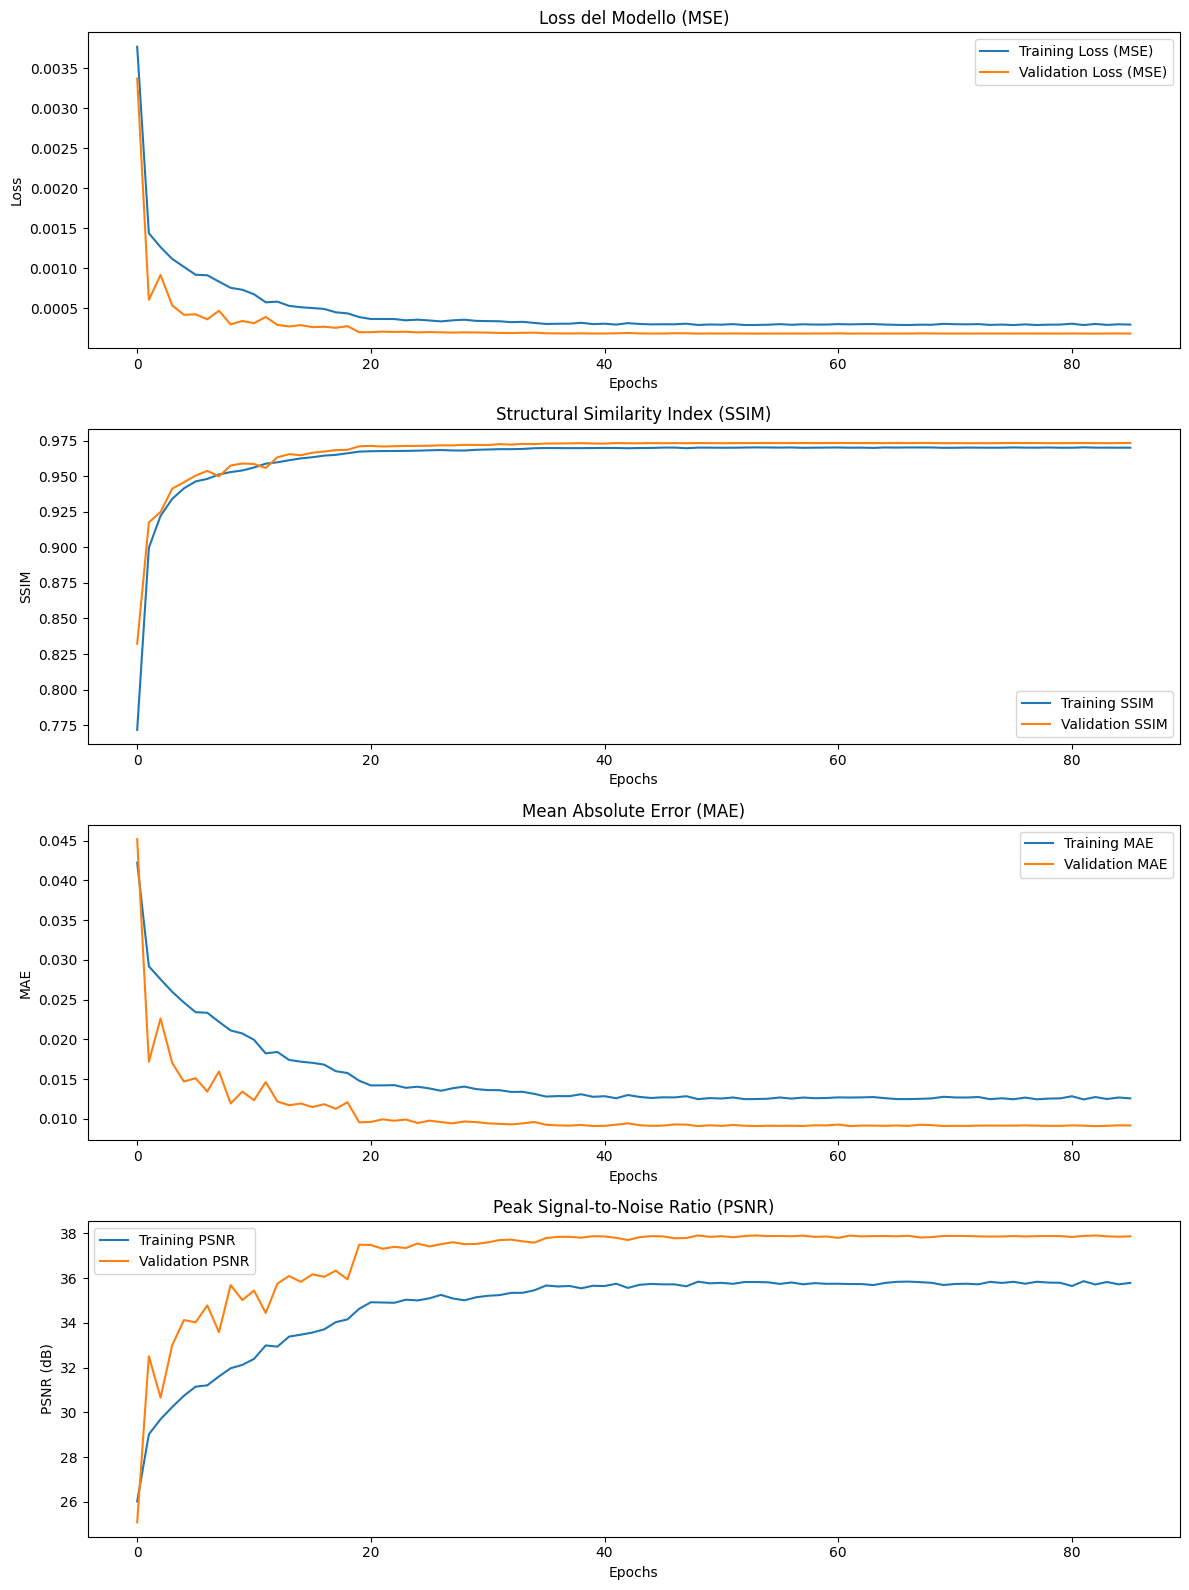

Predizione sul test set...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 128, 96, 3))
  warnings.warn(msg)


48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step
Visualizzazione dei risultati (Originale, Sfocata, De-sfocata)...


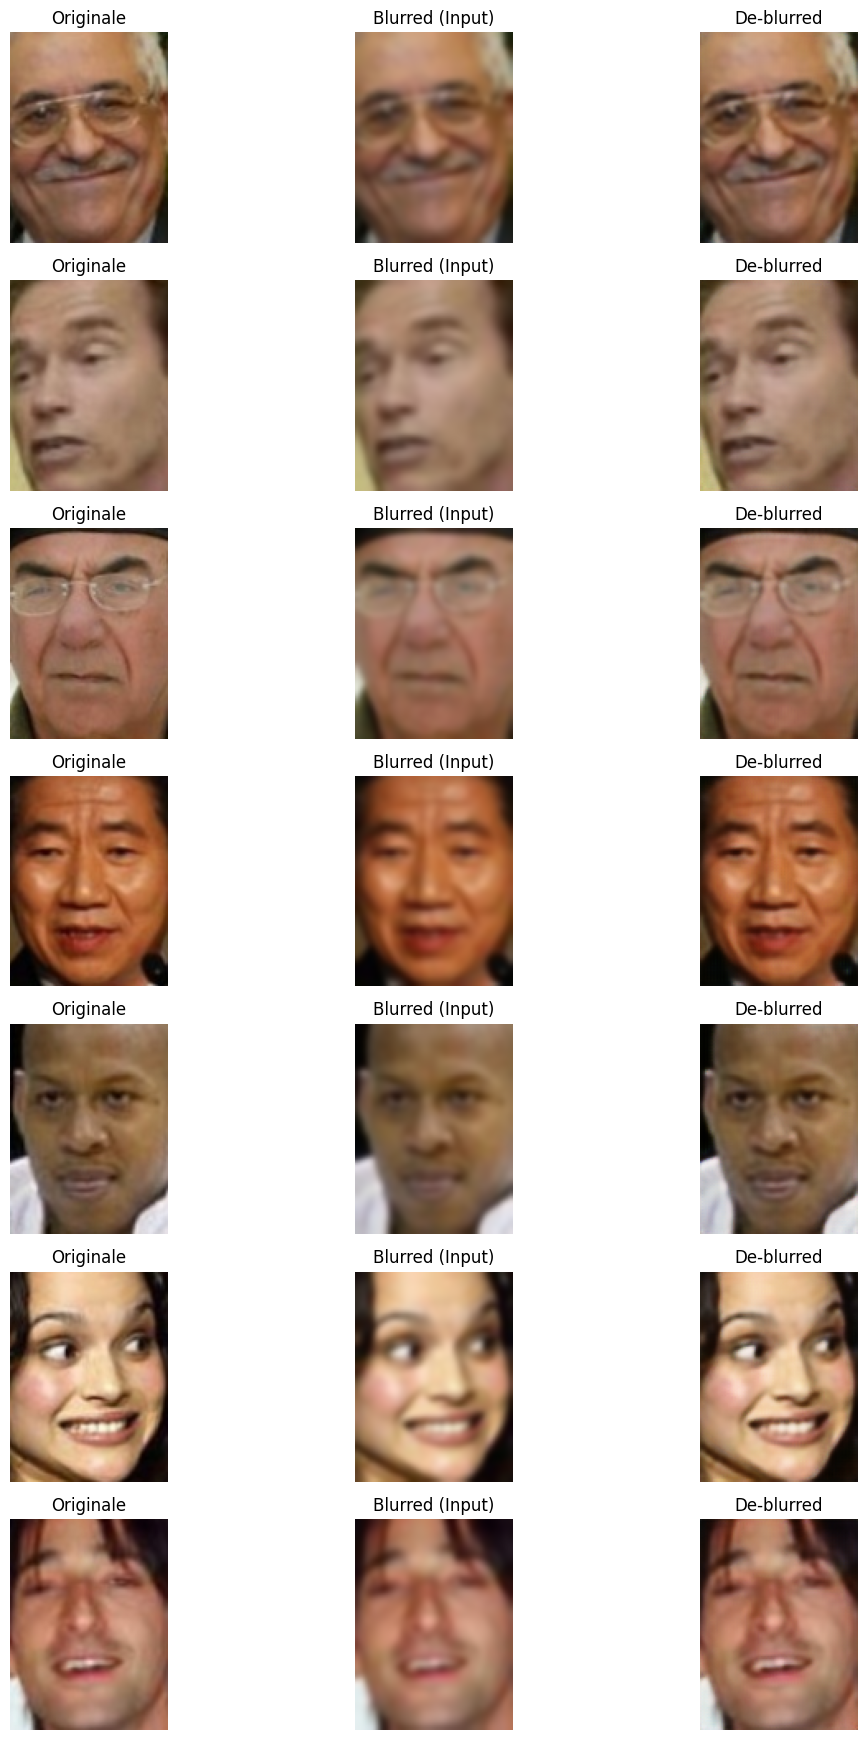

In [ ]:
# 4. Divisione del dataset
x_train_blurred, x_test_blurred, x_train_orig, x_test_orig = train_test_split(
    blurred_images, X, test_size=0.2, random_state=42
)
print(f"Dimensioni Training set: {x_train_blurred.shape[0]} campioni, shape: {x_train_blurred.shape}")
print(f"Dimensioni Test set: {x_test_blurred.shape[0]} campioni, shape: {x_test_blurred.shape}")

# 5. Definizione del modello CNN U-Net Avanzata
input_shape = (h, w, c)
print(f"Input shape per il modello: {input_shape}")

inputs = Input(shape=input_shape)

# Encoder
s1 = conv_block(inputs, 32) # (h, w, 32)
p1 = MaxPooling2D((2, 2))(s1) # (h/2, w/2, 32)

s2 = conv_block(p1, 64) # (h/2, w/2, 64)
p2 = MaxPooling2D((2, 2))(s2) # (h/4, w/4, 64)

s3 = conv_block(p2, 128) # (h/4, w/4, 128)
p3 = MaxPooling2D((2, 2))(s3) # (h/8, w/8, 128)


# Bottleneck
b1 = conv_block(p3, 256) # (h/16, w/16, 512) # O (h/8, w/8, 512) se p4 non esiste

# Decoder
d1= decoder_block(b1, s3, 128)
d2 = decoder_block(d1, s2, 64)
d3 = decoder_block(d2, s1, 32)
# Output layer
outputs = Conv2D(c, (1, 1), activation='sigmoid')(d3) # (h, w, c)

model = Model(inputs=[inputs], outputs=[outputs])

# 6. Compilazione del modello
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='mean_squared_error',
              metrics=[ssim_metric, psnr_metric, 'mean_absolute_error'])
model.summary()

# Callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping = EarlyStopping(monitor='val_ssim_metric', mode='max', patience=20, restore_best_weights=True, verbose=1) # Monitora val_ssim_metric
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-7, verbose=1)

# 7. Addestramento
print("Inizio addestramento del modello U-Net Avanzata...")
epochs = 100
batch_size = 12

history = model.fit(
    x_train_blurred, x_train_orig,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_test_blurred, x_test_orig),
    callbacks=[early_stopping, reduce_lr, tensorboard_callback], # Aggiunto TensorBoard
    verbose=1
)

print("Addestramento completato.")
# more vertical space for 4 plots


# Grafico della loss e delle metriche
plt.figure(figsize=(12, 16)) # Aumentata dimensione figura
plt.subplot(4, 1, 1)
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Loss del Modello (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(history.history['ssim_metric'], label='Training SSIM')
plt.plot(history.history['val_ssim_metric'], label='Validation SSIM')
plt.title('Structural Similarity Index (SSIM)')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(history.history.get('mean_absolute_error', []), label='Training MAE')
plt.plot(history.history.get('val_mean_absolute_error', []), label='Validation MAE')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(history.history['psnr_metric'], label='Training PSNR')
plt.plot(history.history['val_psnr_metric'], label='Validation PSNR')
plt.title('Peak Signal-to-Noise Ratio (PSNR)')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()

plt.tight_layout()
plt.show()

# 8. Valutazione e visualizzazione
print("Predizione sul test set...")
deblurred_test_images = model.predict(x_test_blurred)

print("Visualizzazione dei risultati (Originale, Sfocata, De-sfocata)...")
num_examples_to_show = min(7, len(x_test_orig))
display_images(x_test_orig, x_test_blurred, deblurred_test_images, num_examples=num_examples_to_show)

## Motion Blur

Caricamento del dataset LFW (volti interi)...
Dataset caricato: 7606 immagini, dimensioni originali (dopo fetch resize): 125x94x3
Ridimensionamento immagini a 128x96...
Immagini elaborate per il modello: 7606 immagini di dimensioni 128x96x3
Applicando motion blur a 0 immagini e Gaussian blur a 7606 immagini...

 Motion Blur


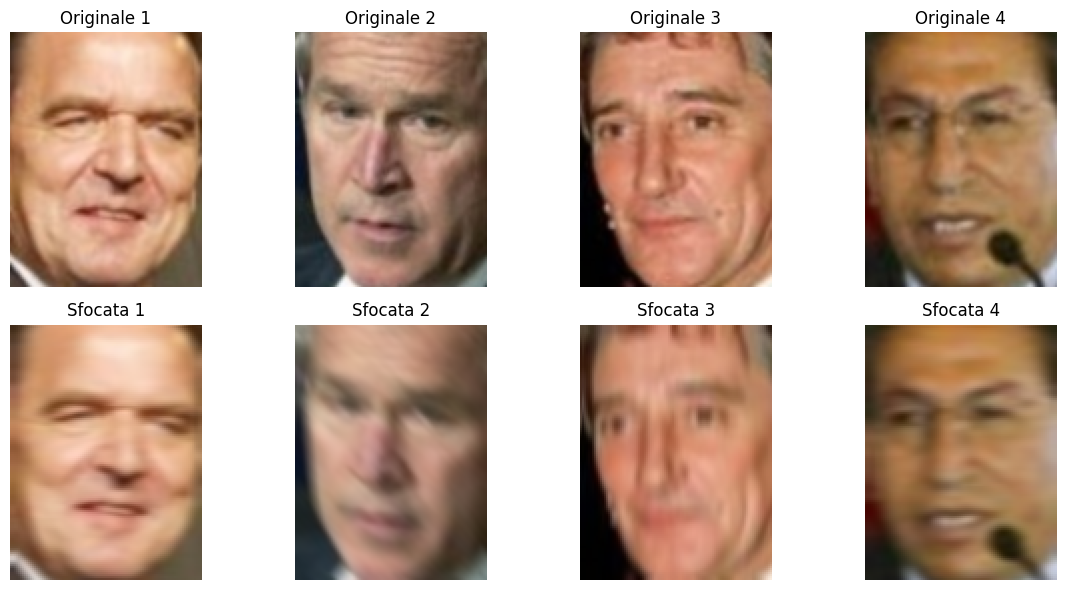

In [ ]:
print("Caricamento del dataset LFW (volti interi)...")

lfw_people = fetch_lfw_people(min_faces_per_person=3, resize=1, color=True)


original_images_from_fetch = lfw_people.images
if original_images_from_fetch.ndim == 3: # Gestione caricamento in scala di grigi per errore
    original_images_from_fetch = np.expand_dims(original_images_from_fetch, axis=-1)
    print("Immagini convertite in formato con canale colore.")

n_samples_fetch, h_fetch, w_fetch, c_fetch = original_images_from_fetch.shape
print(f"Dataset caricato: {n_samples_fetch} immagini, dimensioni originali (dopo fetch resize): {h_fetch}x{w_fetch}x{c_fetch}")

# 2. Ridimensionamento a dimensioni compatibili con la U-Net più profonda
# Con 3 livelli di pooling, le dimensioni devono essere divisibili per 2^3 = 8.
target_h = 128 # Divisibile per 8
target_w = 96 # Divisibile per 8 (aspect ratio circa 4:3)

print(f"Ridimensionamento immagini a {target_h}x{target_w}...")
resized_images_list = []
for img in original_images_from_fetch:
    resized_img = cv2.resize(img, (target_w, target_h), interpolation=cv2.INTER_AREA)
    resized_images_list.append(resized_img)

X = np.array(resized_images_list).astype(np.float32)
if X.max() > 1.0: # Normalizzazione se non già fatta (LFW dovrebbe essere già [0,1])
    X = X / 255.0
X = np.clip(X, 0.0, 1.0)

n_samples, h, w, c = X.shape
print(f"Immagini elaborate per il modello: {n_samples} immagini di dimensioni {h}x{w}x{c}")
if c != 3:
    print(f"ATTENZIONE: Numero di canali inatteso: {c}. Previsti 3 canali colore.")
    # Tentativo di correzione se le immagini sono in scala di grigi
    if c == 1:
        X = np.concatenate([X, X, X], axis=-1)
        c = X.shape[-1]
        print(f"Immagini convertite forzatamente a {c} canali.")


def apply_motion_blur(image, kernel_size=6, direction='horizontal'):
    kernel = np.zeros((kernel_size, kernel_size))

    if direction == 'horizontal':
        kernel[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
    elif direction == 'vertical':
        kernel[:, int((kernel_size - 1)/2)] = np.ones(kernel_size)
    elif direction == 'diagonal':
        np.fill_diagonal(kernel, 1)
    else:
        raise ValueError("direction deve essere 'horizontal', 'vertical', o 'diagonal'")

    kernel /= kernel_size
    return cv2.filter2D(image, -1, kernel)

def apply_mixed_blur(images, motion_ratio=0.3):
    blurred_images = np.zeros_like(images)
    n_motion = int(len(images) * motion_ratio)

    print(f"Applicando motion blur a {n_motion} immagini e Gaussian blur a {len(images) - n_motion} immagini...")

    for i in range(len(images)):
        direction = np.random.choice(['horizontal', 'vertical', 'diagonal'])
        kernel_size = 8  # Dimensione variabile
        blurred_images[i] = apply_motion_blur(images[i], kernel_size, direction)

    return np.clip(blurred_images, 0.0, 1.0)



# Applica motion blur a tutte le immagini
blurred_images = apply_mixed_blur(X, motion_ratio=0)
print("\n Motion Blur")
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    # Immagini originali
    axes[0, i].imshow(X[i])
    axes[0, i].set_title(f'Originale {i+1}')
    axes[0, i].axis('off')

    # Immagini sfocate
    axes[1, i].imshow(blurred_images[i])
    axes[1, i].set_title(f'Sfocata {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Dimensioni Training set: 6084 campioni, shape: (6084, 128, 96, 3)
Dimensioni Test set: 1522 campioni, shape: (1522, 128, 96, 3)
Input shape per il modello: (128, 96, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 96,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 96,   │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 96,   │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 96,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 48,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 48,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 48,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 24,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 24,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 24,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 24,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 12,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 12,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 16, 12,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 24,    │    131,200 │ activation_3[0][

 Total params: 950,883 (3.63 MB)

 Trainable params: 949,475 (3.62 MB)

 Non-trainable params: 1,408 (5.50 KB)

Inizio addestramento del modello U-Net Avanzata...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(12, 128, 96, 3))
  warnings.warn(msg)


507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0107 - mean_absolute_error: 0.0676 - psnr_metric: 22.0095 - ssim_metric: 0.6004

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 96, 3))
  warnings.warn(msg)


507/507 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - loss: 0.0107 - mean_absolute_error: 0.0676 - psnr_metric: 22.0147 - ssim_metric: 0.6007 - val_loss: 0.0054 - val_mean_absolute_error: 0.0573 - val_psnr_metric: 23.0219 - val_ssim_metric: 0.7744 - learning_rate: 1.0000e-04
Epoch 2/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 0.0023 - mean_absolute_error: 0.0354 - psnr_metric: 26.8266 - ssim_metric: 0.8279 - val_loss: 0.0015 - val_mean_absolute_error: 0.0262 - val_psnr_metric: 28.7272 - val_ssim_metric: 0.8475 - learning_rate: 1.0000e-04
Epoch 3/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - loss: 0.0021 - mean_absolute_error: 0.0336 - psnr_metric: 27.3273 - ssim_metric: 0.8496 - val_loss: 0.0012 - val_mean_absolute_error: 0.0235 - val_psnr_metric: 29.4977 - val_ssim_metric: 0.8622 - learning_rate: 1.0000e-04
Epoch 4/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 0.0019 - mean_absolute_error: 0.0324 - psnr_metric: 27.6539 - ssim_metric: 0.8597 - val_loss: 0.0012 - val_mean_

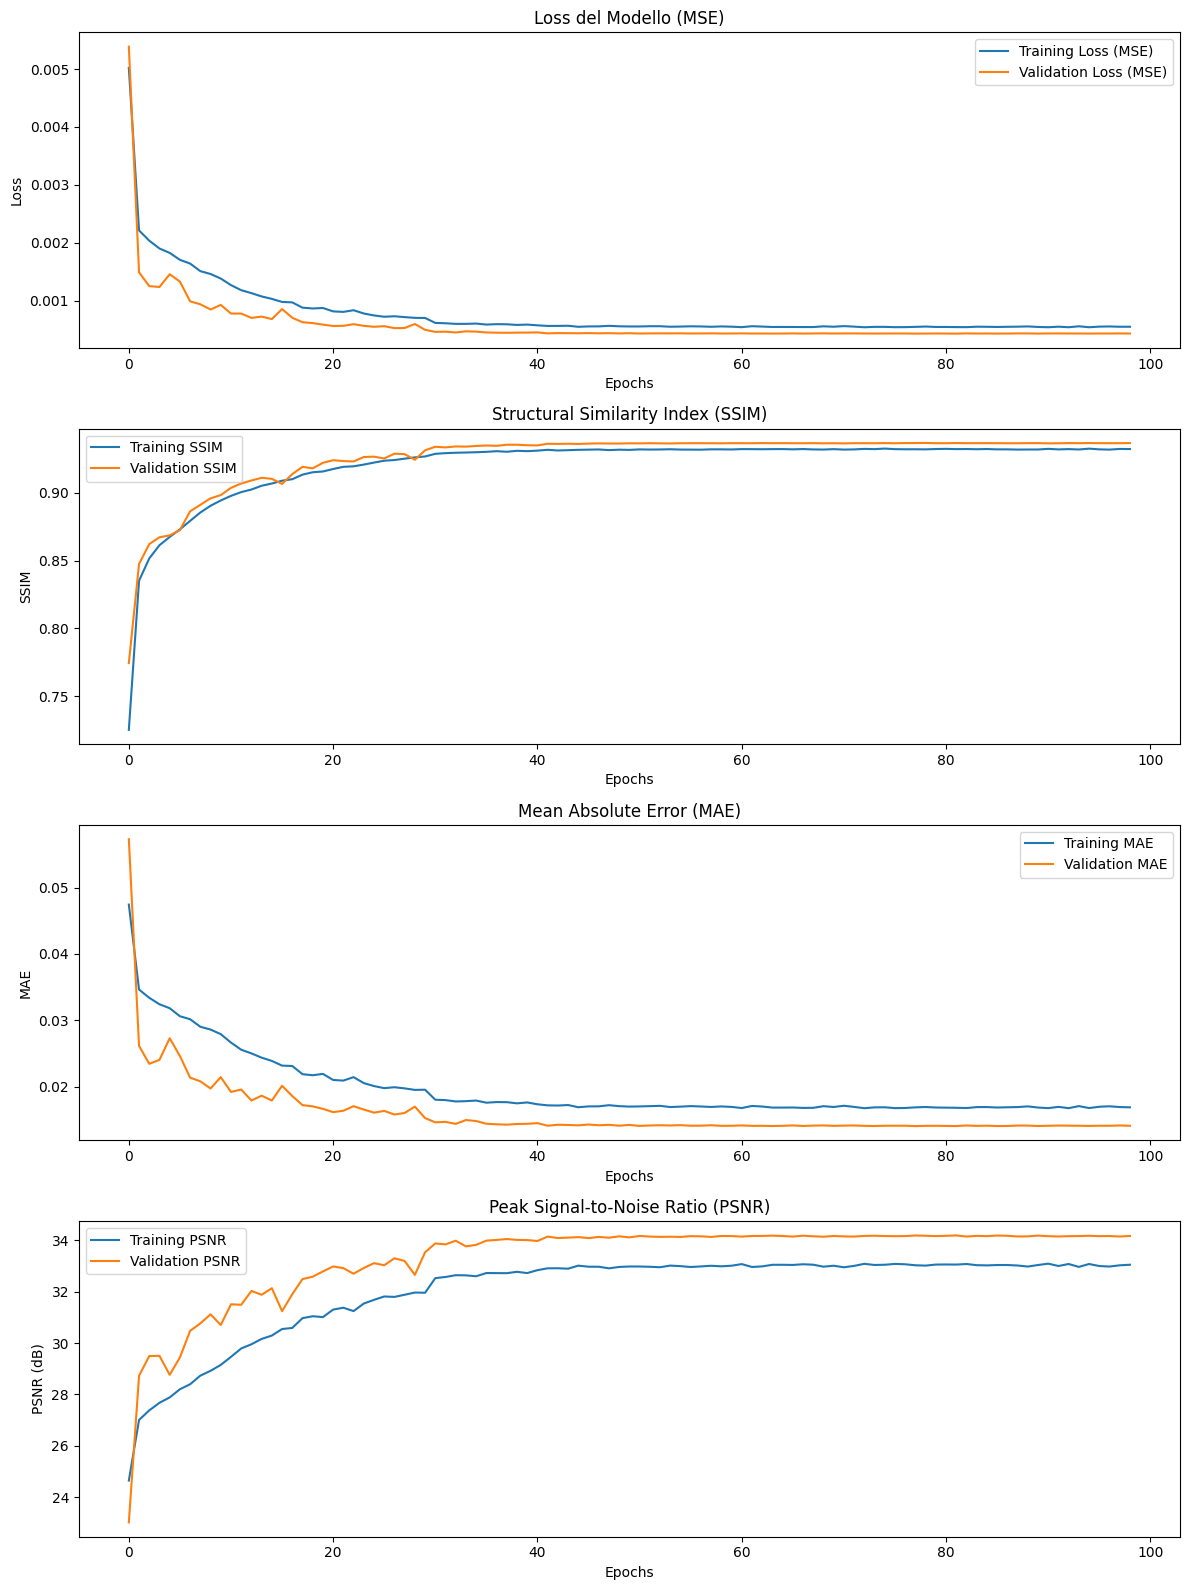

Predizione sul test set...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 128, 96, 3))
  warnings.warn(msg)


48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step
Visualizzazione dei risultati (Originale, Sfocata, De-sfocata)...


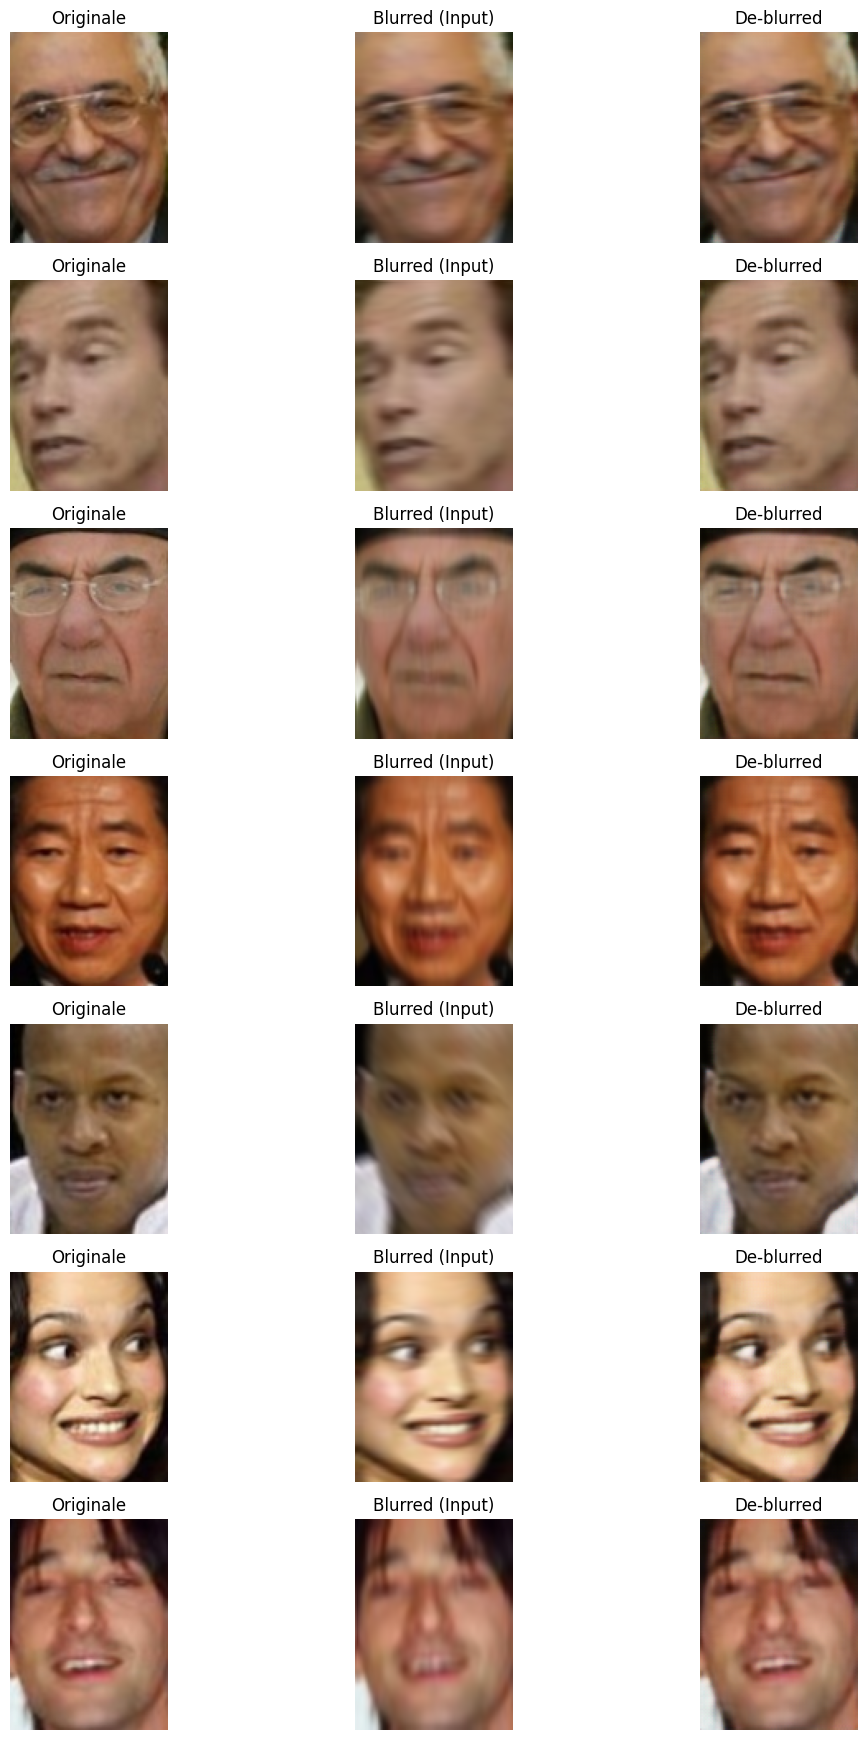

In [ ]:
# 4. Divisione del dataset
x_train_blurred, x_test_blurred, x_train_orig, x_test_orig = train_test_split(
    blurred_images, X, test_size=0.2, random_state=42
)
print(f"Dimensioni Training set: {x_train_blurred.shape[0]} campioni, shape: {x_train_blurred.shape}")
print(f"Dimensioni Test set: {x_test_blurred.shape[0]} campioni, shape: {x_test_blurred.shape}")

# 5. Definizione del modello CNN U-Net Avanzata
input_shape = (h, w, c)
print(f"Input shape per il modello: {input_shape}")

inputs = Input(shape=input_shape)

# Encoder
s1 = conv_block(inputs, 32) # (h, w, 32)
p1 = MaxPooling2D((2, 2))(s1) # (h/2, w/2, 32)

s2 = conv_block(p1, 64) # (h/2, w/2, 64)
p2 = MaxPooling2D((2, 2))(s2) # (h/4, w/4, 64)

s3 = conv_block(p2, 128) # (h/4, w/4, 128)
p3 = MaxPooling2D((2, 2))(s3) # (h/8, w/8, 128)


# Bottleneck
b1 = conv_block(p3, 256) # (h/16, w/16, 512) # O (h/8, w/8, 512) se p4 non esiste

# Decoder
d1= decoder_block(b1, s3, 128) # (h/4 -> h/2, w/4 -> w/2, 128) concatenato con s3 (h/4, w/4, 128) - **ERRORE QUI*
d2 = decoder_block(d1, s2, 64)  # (h/2 -> h, w/2 -> w, 64) concatenato con s2 (h/2, w/2, 64)
d3 = decoder_block(d2, s1, 32)  # (h -> 2h, w -> 2w, 32) concatenato con s1 (h, w, 32)
# Output layer
outputs = Conv2D(c, (1, 1), activation='sigmoid')(d3) # (h, w, c)

model = Model(inputs=[inputs], outputs=[outputs])

# 6. Compilazione del modello
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='mean_squared_error',
              metrics=[ssim_metric, psnr_metric, 'mean_absolute_error'])
model.summary()

# Callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping = EarlyStopping(monitor='val_ssim_metric', mode='max', patience=20, restore_best_weights=True, verbose=1) # Monitora val_ssim_metric
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-7, verbose=1)

# 7. Addestramento
print("Inizio addestramento del modello U-Net Avanzata...")
epochs = 100
batch_size = 12 # Ridotto per modello più grande e immagini più grandi

history = model.fit(
    x_train_blurred, x_train_orig,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_test_blurred, x_test_orig),
    callbacks=[early_stopping, reduce_lr, tensorboard_callback], # Aggiunto TensorBoard
    verbose=1
)

print("Addestramento completato.")

# Grafico della loss e delle metriche
plt.figure(figsize=(12, 16)) # Aumentata dimensione figura
plt.subplot(4, 1, 1)
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Loss del Modello (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(history.history['ssim_metric'], label='Training SSIM')
plt.plot(history.history['val_ssim_metric'], label='Validation SSIM')
plt.title('Structural Similarity Index (SSIM)')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(history.history.get('mean_absolute_error', []), label='Training MAE')
plt.plot(history.history.get('val_mean_absolute_error', []), label='Validation MAE')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(history.history['psnr_metric'], label='Training PSNR')
plt.plot(history.history['val_psnr_metric'], label='Validation PSNR')
plt.title('Peak Signal-to-Noise Ratio (PSNR)')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()

plt.tight_layout()
plt.show()

# 8. Valutazione e visualizzazione
print("Predizione sul test set...")
deblurred_test_images = model.predict(x_test_blurred)

print("Visualizzazione dei risultati (Originale, Sfocata, De-sfocata)...")
num_examples_to_show = min(7, len(x_test_orig))
display_images(x_test_orig, x_test_blurred, deblurred_test_images, num_examples=num_examples_to_show)

In [ ]:
test_psnr_values = tf.image.psnr(x_test_orig, deblurred_test_images, max_val=1.0)
print(f"Average PSNR on test set: {tf.reduce_mean(test_psnr_values).numpy():.2f} dB")